# Audio Mining Notebook, Spring Rotation 2025, SALT Lab
Steven Dillmann, Stanford University, stevendi@stanford.edu

In [1]:
# External imports
from datasets import load_dataset
from datasets import concatenate_datasets
import os
from huggingface_hub import login
from IPython.display import Audio, display
import requests
import soundfile as sf
import io
from dotenv import load_dotenv
from cartesia import Cartesia
from cartesia.voice_changer.client import VoiceChangerClient
import wizmap 
from sentence_transformers import SentenceTransformer
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import umap
import plotly.express as px
import pandas as pd
import numpy as np
np.Infinity = np.inf

# Internal imports
from utils.voice_changer import VoiceChanger

# API Keys
load_dotenv()
hf_key = os.getenv("HF_API_KEY")
cartesia_key = os.getenv(("CARTESIA_API_KEY"))
login(hf_key)
os.environ["CARTESIA_API_KEY"] = cartesia_key


/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data

#### Load Data

In [2]:
# === Load Data ===

# Load the dataset
gs = load_dataset("speechcolab/gigaspeech", "xs", trust_remote_code=True)
gs = concatenate_datasets([ds for ds in gs.values()])
print(gs)

Dataset({
    features: ['segment_id', 'speaker', 'text', 'audio', 'begin_time', 'end_time', 'audio_id', 'title', 'url', 'source', 'category', 'original_full_path'],
    num_rows: 41758
})


#### Display Audio Data 

In [3]:
# === Display Audio Example ===

# Choose example
example_id = 1
audio_input = gs[example_id]["audio"] 
transcription = gs[example_id]["text"]
full_path = gs[example_id]["original_full_path"]

# Display the audio
display(Audio(audio_input["array"], rate=audio_input["sampling_rate"]))
print("Transcription:", transcription)
print("Original Full Path:", full_path)

# Save the audio to a file .wav
sf.write("audio.wav", audio_input["array"], audio_input["sampling_rate"])

# Load the audio file
# audio, samplerate = sf.read("audio.wav")
# print("Audio shape:", audio.shape)
# print("Sample rate:", samplerate)

Transcription: SIX TOMATOES <PERIOD>
Original Full Path: audio/audiobook/P0011/AUD0000001043.opus


#### Stitch Audio Data

In [18]:
# === Stitch Audio ===

# Filter for the same full path
df_path = gs.filter(lambda example: example["original_full_path"] == full_path)
print("Number of examples with the same full path:", len(df_path))

# Stitch the audio
df_path = df_path.sort("segment_id")
for i in range(10):
  print(df_path[i]['segment_id'])
  print(df_path[i]['speaker'])
  print(df_path[i]['text'])
  print(df_path[i]['begin_time'])
  print(df_path[i]['end_time'])
  
  display(Audio(df_path[i]["audio"]["array"], rate=df_path[i]["audio"]["sampling_rate"]))

Number of examples with the same full path: 1057
AUD0000001043_S0000006
N/A
BUT BEYOND THIS POINT THE SITUATION WAS BITTER <PERIOD>
58.95000076293945
62.93000030517578


AUD0000001043_S0000007
N/A
HIS TWO KIDS <COMMA> BUBS <COMMA> SEVEN <COMMA> AND EVELYN <COMMA> NINE CLAD IN SPACE-SUITS THAT WERE SLIGHTLY OVERSIZE TO ALLOW FOR THE GROWTH OF YOUNG BODIES WERE BOTH BAWLING <PERIOD>
63.40999984741211
73.79000091552734


AUD0000001043_S0000008
N/A
HE COULD HEAR THEM THROUGH HIS OXYGEN-HELMET RADIOPHONES <PERIOD>
74.0
77.5199966430664


AUD0000001043_S0000010
N/A
AT HIS ELBOW <COMMA> HIS WIFE <COMMA> ROSE <COMMA> HER HEART-SHAPED FACE AND GREY EYES FRAMED BY THE WIDE FACE-WINDOW OF HER ARMOR <COMMA>
91.0199966430664
99.41999816894531


AUD0000001043_S0000011
N/A
WAS TRYING DESPERATELY TO CHOKE BACK TEARS <COMMA> AND BE BRAVE <PERIOD>
99.41999816894531
103.2300033569336


AUD0000001043_S0000012
N/A
REMEMBER WE'VE GOT TO MAKE GOOD HERE <COMMA> JOHNNY <COMMA>
104.16000366210938
107.86000061035156


AUD0000001043_S0000013
N/A
SHE WAS SAYING <PERIOD>
108.16000366210938
109.30000305175781


AUD0000001043_S0000014
N/A
REMEMBER WHAT THE HOMESTEADERS OFFICE PEOPLE TOLD US THAT WITH MODERN EQUIPMENT AND THE RIGHT FRAME OF MIND <COMMA>
109.69000244140625
115.30000305175781


AUD0000001043_S0000015
N/A
LIFE CAN BE NICE OUT HERE <PERIOD>
115.30000305175781
117.19000244140625


AUD0000001043_S0000016
N/A
IT'S WORKED ON OTHER ASTEROIDS <PERIOD>
117.27999877929688
119.41000366210938


## 2. Voice Changer

In [5]:
# List voices
client = Cartesia(api_key=cartesia_key)

# Get all available Voices
voices = client.voices.list()
for voice in voices:
    print(voice)

id='bf0a246a-8642-498a-9950-80c35e9276b5' is_owner=False name='Sophie' description='A calm, conversational, feminine voice perfect for narration stories or on phone calls. ' created_at=datetime.datetime(2025, 3, 4, 23, 21, 59, 352339, tzinfo=TzInfo(UTC)) embedding=None is_starred=None language='en' mode='similarity' gender='feminine'
id='78ab82d5-25be-4f7d-82b3-7ad64e5b85b2' is_owner=False name='Savannah' description='A smooth, calm Southern female voice. ' created_at=datetime.datetime(2025, 3, 28, 16, 52, 5, 136774, tzinfo=TzInfo(UTC)) embedding=None is_starred=None language='en' mode='similarity' gender='feminine'
id='6f84f4b8-58a2-430c-8c79-688dad597532' is_owner=False name='Brooke' description='A friendly and natural American female voice that feels warm, engaging, and easy to listen to in any conversation.' created_at=datetime.datetime(1970, 4, 18, 0, 0, 20, tzinfo=TzInfo(UTC)) embedding=None is_starred=None language='en' mode='similarity' gender='feminine'
id='a8a1eb38-5f15-4c1d-

In [6]:
# Change voice
vc = VoiceChanger(api_key = cartesia_key, config_path="utils/configs/voice_changer_config.yaml")
input_audio_path = "audio.wav"
output_audio_path = "audio_changed.wav"
vc.run_pipeline(input_audio_path, output_audio_path)

✅ Voice transformation successful.


In [7]:
# Stitch the audio
df_path = df_path.sort("segment_id")
for i in range(10):
  print(df_path[i]['segment_id'])
  print(df_path[i]['text'])
  audio_input = df_path[i]["audio"] 
  # save the audio to a file
  sf.write(f"audio{i}.wav", audio_input["array"], audio_input["sampling_rate"])
  vc.run_pipeline(f"audio{i}.wav", f"audio_changed{i}.wav")


AUD0000001043_S0000006
BUT BEYOND THIS POINT THE SITUATION WAS BITTER <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000007
HIS TWO KIDS <COMMA> BUBS <COMMA> SEVEN <COMMA> AND EVELYN <COMMA> NINE CLAD IN SPACE-SUITS THAT WERE SLIGHTLY OVERSIZE TO ALLOW FOR THE GROWTH OF YOUNG BODIES WERE BOTH BAWLING <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000008
HE COULD HEAR THEM THROUGH HIS OXYGEN-HELMET RADIOPHONES <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000010
AT HIS ELBOW <COMMA> HIS WIFE <COMMA> ROSE <COMMA> HER HEART-SHAPED FACE AND GREY EYES FRAMED BY THE WIDE FACE-WINDOW OF HER ARMOR <COMMA>
✅ Voice transformation successful.


AUD0000001043_S0000011
WAS TRYING DESPERATELY TO CHOKE BACK TEARS <COMMA> AND BE BRAVE <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000012
REMEMBER WE'VE GOT TO MAKE GOOD HERE <COMMA> JOHNNY <COMMA>
✅ Voice transformation successful.


AUD0000001043_S0000013
SHE WAS SAYING <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000014
REMEMBER WHAT THE HOMESTEADERS OFFICE PEOPLE TOLD US THAT WITH MODERN EQUIPMENT AND THE RIGHT FRAME OF MIND <COMMA>
✅ Voice transformation successful.


AUD0000001043_S0000015
LIFE CAN BE NICE OUT HERE <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000016
IT'S WORKED ON OTHER ASTEROIDS <PERIOD>
✅ Voice transformation successful.


## 3. Sentence Embeddings

/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Cosine similarity between sentence 0 and 1: 0.5279
Cosine similarity between sentence 1 and 2: 0.5623
Cosine similarity between sentence 2 and 3: 0.3285
Cosine similarity between sentence 3 and 4: 0.4922


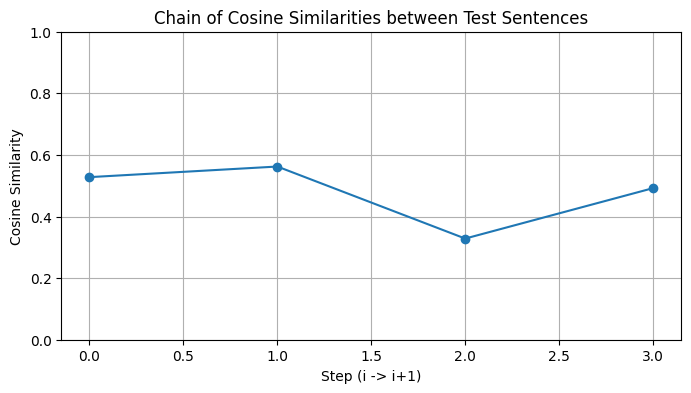

In [ ]:
# === Sentence-BERT Embeddings ===

# Example data
sentences_extra = [
    "HELLO, HOW ARE YOU TODAY?",
    "SO, HOW IS IT GOING?",
    "HOW HAVE YOU BEEN?",
    "WHAT'S UP?",
    "WHAT HAVE YOU BEEN UP TO LATELY?"
]
sentences = list(gs['text'][:1000])
sentences += sentences_extra

# Extract embeddings
model = SentenceTransformer('all-MiniLM-L6-v2') 
embeddings = model.encode(sentences, normalize_embeddings=True) 
embeddings_extra = embeddings[1000:]

# UMAP projection
reducer = umap.UMAP(metric="cosine", random_state=42)
coords = reducer.fit_transform(embeddings)

# Plot
df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "label": ["Gigaspeech"] * 1000 + ["Test sentence"] * (len(coords) - 1000),
    "sentence": sentences, # sentences is your list of strings
    "original_full_path": [i for i in gs["original_full_path"][:1000]] + [""] * len(sentences_extra)
})

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="label",
    hover_data={
        "sentence": True,
        "label": True,
        "original_full_path": True,
        "x": False,  # hide x
        "y": False   # hide y
    },
    opacity=0.6,
)

fig.update_traces(marker=dict(size=5))  # Small points
fig.update_layout(
    title="Sentence-BERT embeddings (UMAP)",
    legend_title="Dataset",
    width=800,
    height=600
)

fig.show()



In [9]:
# === WizMap Visualization ===

# Generate two JSON files required by WizMap
xs = coords[:, 0].astype(float).tolist()
ys = coords[:, 1].astype(float).tolist()
texts = sentences
data_list = wizmap.generate_data_list(xs, ys, texts)
grid_dict = wizmap.generate_grid_dict(xs, ys, texts, 'Sentences')
wizmap.save_json_files(data_list, grid_dict, output_dir = '../embeddings/')

# Load the JSON file urls
data_url = 'https://StevenDillmann.github.io/audio-mining/embeddings/data.ndjson'
grid_url = 'https://StevenDillmann.github.io/audio-mining/embeddings/grid.json'

# Display the WizMap visualization
wizmap.visualize(data_url, grid_url, height=600)


Start generating data list...
Start generating contours...
Start generating multi-level summaries...


1005it [00:00, 352006.31it/s]
100%|██████████| 6/6 [00:00<00:00, 12.66it/s]


<iframe
 srcdoc="<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8" /><meta name="viewport" content="width=device-width, initial-scale=1.0" /><title>WizMap</title><style>html {font-size: 16px;-moz-osx-font-smoothing: grayscale;-webkit-font-smoothing: antialiased;text-rendering: optimizeLegibility;-webkit-text-size-adjust: 100%;-moz-text-size-adjust: 100%;scroll-behavior: smooth;}html, body {position: relative;width: 100%;height: 100%;overscroll-behavior: none;}body {margin: 0px;padding: 0px;box-sizing: border-box;font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen-Sans, Ubuntu, Cantarell, 'Helvetica Neue', sans-serif;color: hsl(0, 0%, 29%);font-size: 1em;font-weight: 400;line-height: 1.5;}*, ::after, ::before {box-sizing: inherit;}a {color: rgb(0, 100, 200);text-decoration: none;}a:hover {text-decoration: underline;}a:visited {color: rgb(0, 80, 160);}label {display: block;}input, select, textarea {font-family: inherit;font-size: inherit;-webkit-padding: 0 0;padding: 0;margin: 0 0 0 0;box-sizing: border-box;border: 1px solid #ccc;border-radius: 2px;}input:disabled {color: #ccc;}button {all: unset;outline: none;cursor: pointer;}</style><script defer src='data:text/javascript;base64,dmFyIHdpem1hcD1mdW5jdGlvbigpeyJ1c2Ugc3RyaWN0Ijt2YXIgSGY9T2JqZWN0LmRlZmluZVByb3BlcnR5O3ZhciBUZj0oZWwsUSxvbik9PlEgaW4gZWw/SGYoZWwsUSx7ZW51bWVyYWJsZTohMCxjb25maWd1cmFibGU6ITAsd3JpdGFibGU6ITAsdmFsdWU6b259KTplbFtRXT1vbjt2YXIgYnQ9KGVsLFEsb24pPT4oVGYoZWwsdHlwZW9mIFEhPSJzeW1ib2wiP1ErIiI6USxvbiksb24pO2Z1bmN0aW9uIGVsKCl7fWZ1bmN0aW9uIFEodCxpLGwsZSxuKXt0Ll9fc3ZlbHRlX21ldGE9e2xvYzp7ZmlsZTppLGxpbmU6bCxjb2x1bW46ZSxjaGFyOm59fX1mdW5jdGlvbiBvbih0KXtyZXR1cm4gdCgpfWZ1bmN0aW9uIHUwKCl7cmV0dXJuIE9iamVjdC5jcmVhdGUobnVsbCl9ZnVuY3Rpb24gb2UodCl7dC5mb3JFYWNoKG9uKX1mdW5jdGlvbiBjMCh0KXtyZXR1cm4gdHlwZW9mIHQ9PSJmdW5jdGlvbiJ9ZnVuY3Rpb24gdWQodCxpKXtyZXR1cm4gdCE9dD9pPT1pOnQhPT1pfHx0JiZ0eXBlb2YgdD09Im9iamVjdCJ8fHR5cGVvZiB0PT0iZnVuY3Rpb24ifWZ1bmN0aW9uIEhaKHQpe3JldHVybiBPYmplY3Qua2V5cyh0KS5sZW5ndGg9PT0wfWZ1bmN0aW9uIGEwKHQsaSl7dC5hcHBlbmRDaGlsZChpKX1mdW5jdGlvbiBobyh0LGksbCl7Y29uc3QgZT1UWih0KTtpZighZS5nZXRFbGVtZW50QnlJZChpKSl7Y29uc3Qgbj1FKCJzdHlsZSIpO24uaWQ9aSxuLnRleHRDb250ZW50PWwsa1ooZSxuKX19ZnVuY3Rpb24gVFoodCl7aWYoIXQpcmV0dXJuIGRvY3VtZW50O2NvbnN0IGk9dC5nZXRSb290Tm9kZT90LmdldFJvb3ROb2RlKCk6dC5vd25lckRvY3VtZW50O3JldHVybiBpJiZpLmhvc3Q/aTp0Lm93bmVyRG9jdW1lbnR9ZnVuY3Rpb24ga1oodCxpKXtyZXR1cm4gYTAodC5oZWFkfHx0LGkpLGkuc2hlZXR9ZnVuY3Rpb24gTVoodCxpLGwpe3QuaW5zZXJ0QmVmb3JlKGksbHx8bnVsbCl9ZnVuY3Rpb24gYjAodCl7dC5wYXJlbnROb2RlLnJlbW92ZUNoaWxkKHQpfWZ1bmN0aW9uIHdaKHQsaSl7Zm9yKGxldCBsPTA7bDx0Lmxlbmd0aDtsKz0xKXRbbF0mJnRbbF0uZChpKX1mdW5jdGlvbiBFKHQpe3JldHVybiBkb2N1bWVudC5jcmVhdGVFbGVtZW50KHQpfWZ1bmN0aW9uIG9jKHQpe3JldHVybiBkb2N1bWVudC5jcmVhdGVFbGVtZW50TlMoImh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIix0KX1mdW5jdGlvbiBkbCh0KXtyZXR1cm4gZG9jdW1lbnQuY3JlYXRlVGV4dE5vZGUodCl9ZnVuY3Rpb24gTnQoKXtyZXR1cm4gZGwoIiAiKX1mdW5jdGlvbiB2Wih0LGksbCxlKXtyZXR1cm4gdC5hZGRFdmVudExpc3RlbmVyKGksbCxlKSwoKT0+dC5yZW1vdmVFdmVudExpc3RlbmVyKGksbCxlKX1mdW5jdGlvbiBKWih0LGksbCl7bD09bnVsbD90LnJlbW92ZUF0dHJpYnV0ZShpKTp0LmdldEF0dHJpYnV0ZShpKSE9PWwmJnQuc2V0QXR0cmlidXRlKGksbCl9ZnVuY3Rpb24gTloodCl7cmV0dXJuIEFycmF5LmZyb20odC5jaGlsZE5vZGVzKX1mdW5jdGlvbiBjZCh0LGkpe3QudmFsdWU9aT09bnVsbD8iIjppfWZ1bmN0aW9uIHJpKHQsaSxsKXt0LmNsYXNzTGlzdFtsPyJhZGQiOiJyZW1vdmUiXShpKX1mdW5jdGlvbiB6Wih0LGkse2J1YmJsZXM6bD0hMSxjYW5jZWxhYmxlOmU9ITF9PXt9KXtjb25zdCBuPWRvY3VtZW50LmNyZWF0ZUV2ZW50KCJDdXN0b21FdmVudCIpO3JldHVybiBuLmluaXRDdXN0b21FdmVudCh0LGwsZSxpKSxufWxldCB0cztmdW5jdGlvbiBpcyh0KXt0cz10fWZ1bmN0aW9uIFBaKCl7aWYoIXRzKXRocm93IG5ldyBFcnJvcigiRnVuY3Rpb24gY2FsbGVkIG91dHNpZGUgY29tcG9uZW50IGluaXRpYWxpemF0aW9uIik7cmV0dXJuIHRzfWZ1bmN0aW9uIGFkKHQpe1BaKCkuJCQub25fbW91bnQucHVzaCh0KX1jb25zdCBscz1bXSx1bj1bXSxabz1bXSxtMD1bXSxGWj1Qcm9taXNlLnJlc29sdmUoKTtsZXQgdWM9ITE7ZnVuY3Rpb24galooKXt1Y3x8KHVjPSEwLEZaLnRoZW4ocjApKX1mdW5jdGlvbiBjYyh0KXtaby5wdXNoKHQpfWNvbnN0IGFjPW5ldyBTZXQ7bGV0IEdvPTA7ZnVuY3Rpb24gcjAoKXtjb25zdCB0PXRzO2Rve2Zvcig7R288bHMubGVuZ3RoOyl7Y29uc3QgaT1sc1tHb1

/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



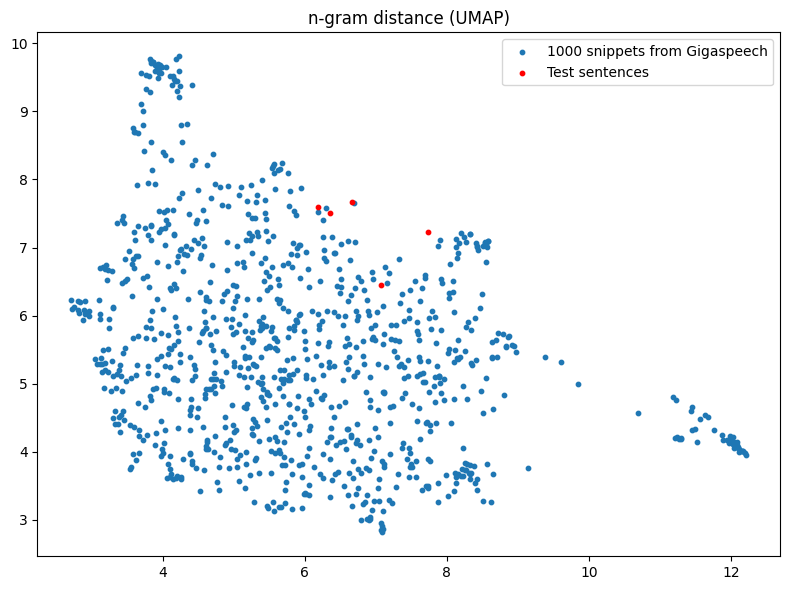

In [ ]:
# # Find 
# import matplotlib.pyplot as plt
# from sklearn.manifold import MDS

# import numpy as np
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import pairwise_distances
# import re
# from itertools import tee
# from typing import List

# # === 1. Preprocessing ===
# def preprocess(sentence: str) -> List[str]:
#     sentence = re.sub(r"[^\w\s]", "", sentence.lower())
#     return sentence.split()

# # === 2. Generate word-level n-grams ===
# def ngrams(words: List[str], n: int) -> List[tuple]:
#     return list(zip(*(tee(words, n))))

# # === 3. Jaccard distance function ===
# def jaccard_dist(s1: str, s2: str, n: int = 2) -> float:
#     ngrams1 = set(ngrams(preprocess(s1), n))
#     ngrams2 = set(ngrams(preprocess(s2), n))
#     if not ngrams1 or not ngrams2:
#         return 1.0  # max distance
#     return 1 - len(ngrams1 & ngrams2) / len(ngrams1 | ngrams2)

# # === 4. Distance matrix computation ===
# def jaccard_distance_matrix(sentences: List[str], n: int = 2) -> np.ndarray:
#     size = len(sentences)
#     dist_matrix = np.zeros((size, size))
#     for i in range(size):
#         for j in range(i + 1, size):
#             dist = jaccard_dist(sentences[i], sentences[j], n)
#             dist_matrix[i][j] = dist_matrix[j][i] = dist
#     return dist_matrix


# dist_matrix = jaccard_distance_matrix(sentences, n=2)
# mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
# coords2 = mds.fit_transform(dist_matrix)

# import umap.umap_ as umap  # make sure you have umap-learn installed

# # Compute the 2D UMAP embedding from the precomputed Jaccard distance matrix
# umap_model = umap.UMAP(n_components=2, metric='precomputed', random_state=0)
# coords2_umap = umap_model.fit_transform(dist_matrix)

# # Plot
# plt.figure(figsize=(8, 6))
# plt.scatter(coords2_umap[:1000, 0], coords2_umap[:1000, 1], label="1000 snippets from Gigaspeech", s=10)
# plt.scatter(coords2_umap[1000:, 0], coords2_umap[1000:, 1], color='red', label="Test sentences", s=10)
# plt.title("n-gram distance (UMAP)")
# plt.legend()
# plt.tight_layout()
# plt.show()
